In [11]:
TEST = True
FOM = True
WRITE = False
%matplotlib inline

In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

from Bio import AlignIO
import time as time
import pandas as pd

#---------------------------------------------------------------------------------------------------------------------------------
'''DEFINE LOOP'''
trials = ['med']#['small', 'med', 'large']
exp = 'toyhp'  #for both the data folder and the params folder
exp_data = 'data_%s'%(exp)

for t in trials:

    #---------------------------------------------------------------------------------------------------------------------------------

    '''OPEN DATA'''

    starttime = time.time()

    #Open data from h5py
    filename = '%s_50k_%s.hdf5'%(exp, t)
    data_path = os.path.join('../..', exp_data, filename)
    with h5py.File(data_path, 'r') as dataset:
        X_data = np.array(dataset['X_data'])
        Y_data = np.array(dataset['Y_data'])

    numdata, seqlen, dims = X_data.shape
    X_data = np.expand_dims(X_data, axis=2)

    # get validation and test set from training set
    test_frac = 0.3
    valid_frac = 0.1
    N = numdata
    split_1 = int(N*(1-valid_frac-test_frac))
    split_2 = int(N*(1-test_frac))
    shuffle = np.random.permutation(N)

    #set up dictionaries
    train = {'inputs': X_data[shuffle[:split_1]], 
           'targets': Y_data[shuffle[:split_1]]}
    valid = {'inputs': X_data[shuffle[split_1:split_2]], 
           'targets': Y_data[shuffle[split_1:split_2]]}
    test = {'inputs': X_data[shuffle[split_2:]], 
           'targets': Y_data[shuffle[split_2:]]}

    print ('Data extraction and dict construction completed in: ' + mf.sectotime(time.time() - starttime))


    #---------------------------------------------------------------------------------------------------------------------------------


    '''SAVE PATHS AND PARAMETERS'''
    params_results = '../../results'

    modelarch = 'resbind'
    trial = t
    modelsavename = '%s_%s'%(modelarch, trial)



    '''BUILD NEURAL NETWORK'''

    def cnn_model(input_shape, output_shape):

        # create model
        layer1 = {'layer': 'input', #41
              'input_shape': input_shape
              }
        layer2 = {'layer': 'conv1d',
              'num_filters': 96,
              'filter_size': input_shape[1]-29,
              'norm': 'batch',
              'activation': 'relu',
              'dropout': 0.3,
              'padding': 'VALID',
              }
        layer3 = {'layer': 'conv1d_residual',
              'filter_size': 5,
              'function': 'relu',
              'dropout_block': 0.1,
              'dropout': 0.3,
              'mean_pool': 10,
              }

        layer4 = {'layer': 'dense',        # input, conv1d, dense, conv1d_residual, dense_residual, conv1d_transpose,
                                      # concat, embedding, variational_normal, variational_softmax, + more
            'num_units': 196,
            'norm': 'batch',          # if removed, automatically adds bias instead
            'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
            'dropout': 0.5,           # if removed, default is no dropout
               }


        layer5 = {'layer': 'dense',
              'num_units': output_shape[1],
              'activation': 'sigmoid'
              }

        model_layers = [layer1, layer2, layer3, layer4, layer5]

        # optimization parameters
        optimization = {"objective": "binary",
                    "optimizer": "adam",
                    "learning_rate": 0.0003,
                    "l2": 1e-5,
                    #"label_smoothing": 0.05,
                    #"l1": 1e-6,
                    }
        return model_layers, optimization

    tf.reset_default_graph()

    # get shapes of inputs and targets
    input_shape = list(train['inputs'].shape)
    input_shape[0] = None
    output_shape = train['targets'].shape

    # load model parameters
    model_layers, optimization = cnn_model(input_shape, output_shape)

    # build neural network class
    nnmodel = nn.NeuralNet(seed=247)
    nnmodel.build_layers(model_layers, optimization)

    # compile neural trainer
    save_path = os.path.join(params_results, exp)
    param_path = os.path.join(save_path, modelsavename)
    nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

    #---------------------------------------------------------------------------------------------------------------------------------

    sess = utils.initialize_session()
    '''TEST'''
    if TEST:

        # set best parameters
        nntrainer.set_best_parameters(sess)

        # test model
        loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')
        if WRITE:
            metricsline = '%s,%s,%s,%s,%s,%s,%s'%(exp, modelarch, trial, loss, mean_vals[0], mean_vals[1], mean_vals[2])
            fd = open('test_metrics.csv', 'a')
            fd.write(metricsline+'\n')
            fd.close()
        '''SORT ACTIVATIONS'''
        nntrainer.set_best_parameters(sess)
        predictionsoutput = nntrainer.get_activations(sess, test, layer='output')
        plot_index = np.argsort(predictionsoutput[:,0])[::-1]

    #---------------------------------------------------------------------------------------------------------------------------------
    '''FIRST ORDER MUTAGENESIS'''
    if FOM:
        num_plots = range(1)
        for ii in num_plots: 

            X = np.expand_dims(test['inputs'][plot_index[10+ii]], axis=0)

            norm_heat_mut = mf.fom_heatmap(X, layer='dense_1_bias', alphabet='rna', nntrainer=nntrainer, sess=sess)


        plt.close()
                # get a test sequence
        #X = np.expand_dims(test['inputs'][index], axis=0)

        

    #---------------------------------------------------------------------------------------------------------------------------------




Data extraction and dict construction completed in: 0.25s
loading model from:  ../../results/toyhp/resbind_med_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/toyhp/resbind_med_best.ckpt
  test  loss:		0.04800
  test  accuracy:	0.99140+/-0.00000
  test  auc-roc:	0.99958+/-0.00000
  test  auc-pr:		0.99938+/-0.00000
loading model from:  ../../results/toyhp/resbind_med_best.ckpt
INFO:tensorflow:Restoring parameters from ../../results/toyhp/resbind_med_best.ckpt


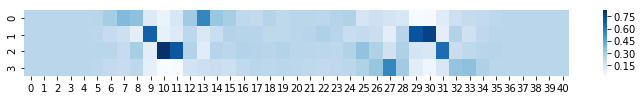

In [24]:
plt.figure(figsize=(10, 1.5))
import seaborn as sb
sb.heatmap(norm_heat_mut, cmap='Blues')

INFO:tensorflow:Restoring parameters from ../../results/toyhp/resbind_med_best.ckpt


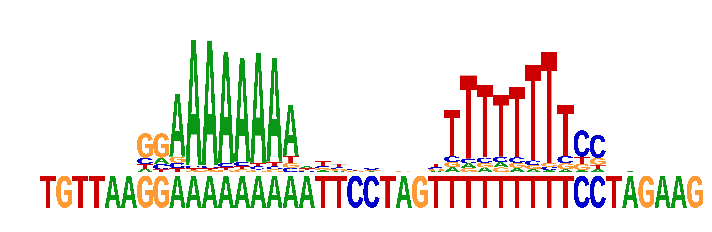

In [55]:
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

X = np.expand_dims(test['inputs'][plot_index[0]], axis=0)

# guided backprop
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

# plot and save saliency
fig = plt.figure(figsize=(10,10))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                np.squeeze(guided_saliency[0]).T, 
                                alphabet='dna', 
                                nt_width=400)

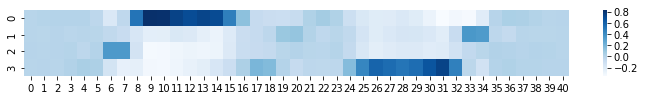

In [56]:
plt.figure(figsize=(10, 1.5))
import seaborn as sb
sb.heatmap(np.squeeze(guided_saliency[0]).T, cmap='Blues')